In [1]:
# inspired from http://peterroelants.github.io/posts/neural_network_implementation_part05/
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EPS = 10e-7

class Layer(object):
    def forward(self, h):
        """ Perform a forward step for the given layer and returns the result
        # Argument
            h: np.array of the previous layer
        # Return
            np.array of the activation 
        """
        
    def backward(self, grad):
        """ Perform the backpropagation of the layer. This method updates weights if necessary
        # Argument
            grad: np.array of the incoming gradient
        # Return
            np.array of the calculated gradient
        """

In [3]:
class Linear(Layer):
    def __init__(self, input_size, nb_neurons, lr=0.0001, freeze=False):
        self._weights = np.random.randn(input_size + 1, nb_neurons) * 0.1
        self.lr = lr
        self.freeze = freeze
        
    def forward(self, h):
        self._h = np.concatenate((np.ones(1), h))
        return self._weights.T.dot(self._h)
    
    def backward(self, grad):
        if not self.freeze:
            dW = grad[:, np.newaxis].dot(self._h[:, np.newaxis].T).T
            self._weights -= self.lr * dW
        return grad.dot(self._weights.T)
    
class Relu(Layer):
    def forward(self, h):
        self._h = h
        return np.maximum(0, h)
    
    def backward(self, grad):
        return np.multiply(grad[1:], (self._h >= 0).astype(dtype=np.float))
    
class Sigmoid(Layer):
    def forward(self, h):
        self._h = h
        return 1 / (1 - np.exp(-h))
    
    def backward(self, grad):
        pass
    
class Softmax(Layer):
    def forward(self, h):
        self._h = h
        s = np.sum(np.exp(h))
        return np.exp(h) / s
    
    def backward(self, y_true):
        return self._h - y_true
    
def categorical_cross_entropy(y_true, y_pred):
    return - np.multiply(y_true, np.log(y_pred + EPS)).sum()

In [4]:
class Model(object):
    def __init__(self, cost):
        self._layers = []
        self._activations = []
        self._cost = cost

    def add_layer(self, layer):
        self._layers.append(layer)
        
    def get_cost(self, y_true , y_pred):
        return self._cost(y_true, y_pred)
        
    def propagate(self, x):
        self._activations = [x]
        for layer in self._layers:
            self._activations.append(layer.forward(self._activations[-1]))
            
    def back_prop(self, y):
        cur_grad = None
        for layer in reversed(self._layers):
            Y = self._activations.pop()
            if cur_grad is None:
                cur_grad = layer.backward(y)
            else:
                cur_grad = layer.backward(cur_grad)
                
    def predict(self, X):
        predictions = []
        for x in X:
            self.propagate(x)
            predictions.append(self._activations[-1])
        return np.array(predictions)

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/len(y_pred)
        
            
    def train(self, epochs, X_train, y_train, X_valid=None, y_valid=None):
        n_train, n_valid = len(y_train), len(y_valid)
        loss_epochs = []
        val_loss_epochs = []
        for _ in range(epochs):
            Ls = []
            for i in range(n_train):
                x, y = X_train[i, :], y_train[i, :]
                self.propagate(x)
                L = self.get_cost(y, self._activations[-1])
                Ls.append(L)
                self.back_prop(y)
            loss_epochs.append(np.mean(Ls))
            Ls = []
            for i in range(n_valid):
                x, y = X_valid[i, :], y_valid[i, :]
                self.propagate(x)
                L = self.get_cost(y, self._activations[-1])
                Ls.append(L)
            val_loss_epochs.append(np.mean(Ls))
        plt.title("Loss over {} epochs".format(str(epochs)))
        plt.plot(val_loss_epochs, 'b', label="Val Loss")
        plt.plot(loss_epochs, 'r', label="Loss")
        plt.legend()
        plt.show()

In [5]:
model = Model(categorical_cross_entropy)
model.add_layer(Linear(64, 20))
model.add_layer(Relu())
model.add_layer(Linear(20, 20))
model.add_layer(Relu())
model.add_layer(Linear(20, 10))
model.add_layer(Softmax())

In [6]:
# Test on MNIST
from sklearn import datasets
from keras.utils import to_categorical

# The digits dataset
digits = datasets.load_digits()
targets = digits.target
X, y = digits.data, to_categorical(targets)

Using TensorFlow backend.


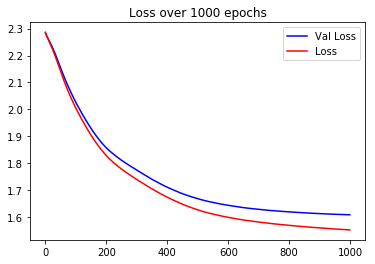

In [7]:
def split_data(X, y, percent):
    split = int(len(y) * percent)
    return X[:split, :], y[:split, :], X[split:, :], y[split:, :]
X = (X - np.mean(X)) / np.std(X)
X_train, y_train, X_valid, y_valid = split_data(X, y, 0.5)
X_valid, y_valid, X_test, y_test = split_data(X_valid, y_valid, 0.5)
model.train(1000, X_train, y_train, X_valid, y_valid)

In [8]:
score = model.score(X_test, y_test)
print("Accuracy = {}".format(str(score)))

Accuracy = 0.9066666666666666
